## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from model_classes import HealthModel
import torch
from datetime import datetime as dt

## Config

Linear regressor config:

In [63]:
config = {
    "architecture": "linear_regressor",
    "train_size": 0.8,
    "val_size": False, # Set MLP 
    "hidden_layer_sizes": False, # configs
    "batch_size": False, # to False
    "num_epochs": False, # if using
    "learning_rate": False, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "met_variables": ["temperature"] # Set to False if excluding meteorology
    }

plot_title_model = "(all inputs)"

MLP regressor config:

In [49]:
config = {
    "architecture": "MLP_regressor",
    "train_size": 0.7,
    "val_size": 0.15, # Set MLP configs
    "hidden_layer_sizes": [10],
    "batch_size": 30, # to False
    "num_epochs": 100, # if using
    "learning_rate": 0.001, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample"], #, "income-regional"
    "met_variables": ["temperature"] # Set to False if excluding meteorology
    }

plot_title_model = "(excluding income)"
torch.manual_seed(1)

## Code

In [64]:
model = HealthModel(config)

In [65]:
model.preprocess_and_log()

In [66]:
model.train_and_log()

r_squared,0.62525
mean_squared_error,0.06999
mean_absolute_percentage_error,9.3584
_runtime,8
_timestamp,1622821777
_step,0


r_squared,▁
mean_squared_error,▁
mean_absolute_percentage_error,▁
_runtime,▁
_timestamp,▁
_step,▁


In [67]:
data_dict = model.test_and_log()

r_squared,-3.04346
mean_squared_error,0.20426
mean_absolute_percentage_error,25.14131
_runtime,11
_timestamp,1622821794
_step,0


r_squared,▁
mean_squared_error,▁
mean_absolute_percentage_error,▁
_runtime,▁
_timestamp,▁
_step,▁


#### Alternative
If the model has already been run, lookup the test_and_log output artifact version on the wandb web interface and read it in here:

In [68]:
#data_dict = model.read_data("xy_all", "v2") 

## Plot results

In [69]:
df = pd.DataFrame()
subsets = ["train", "validat", "test"] if config["val_size"] else ["train", "test"]
for subset in subsets:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"], "predicted":data_dict[f"y_{subset}_predict"]})
    df = subset_df.copy() if df.empty else df.append(subset_df)

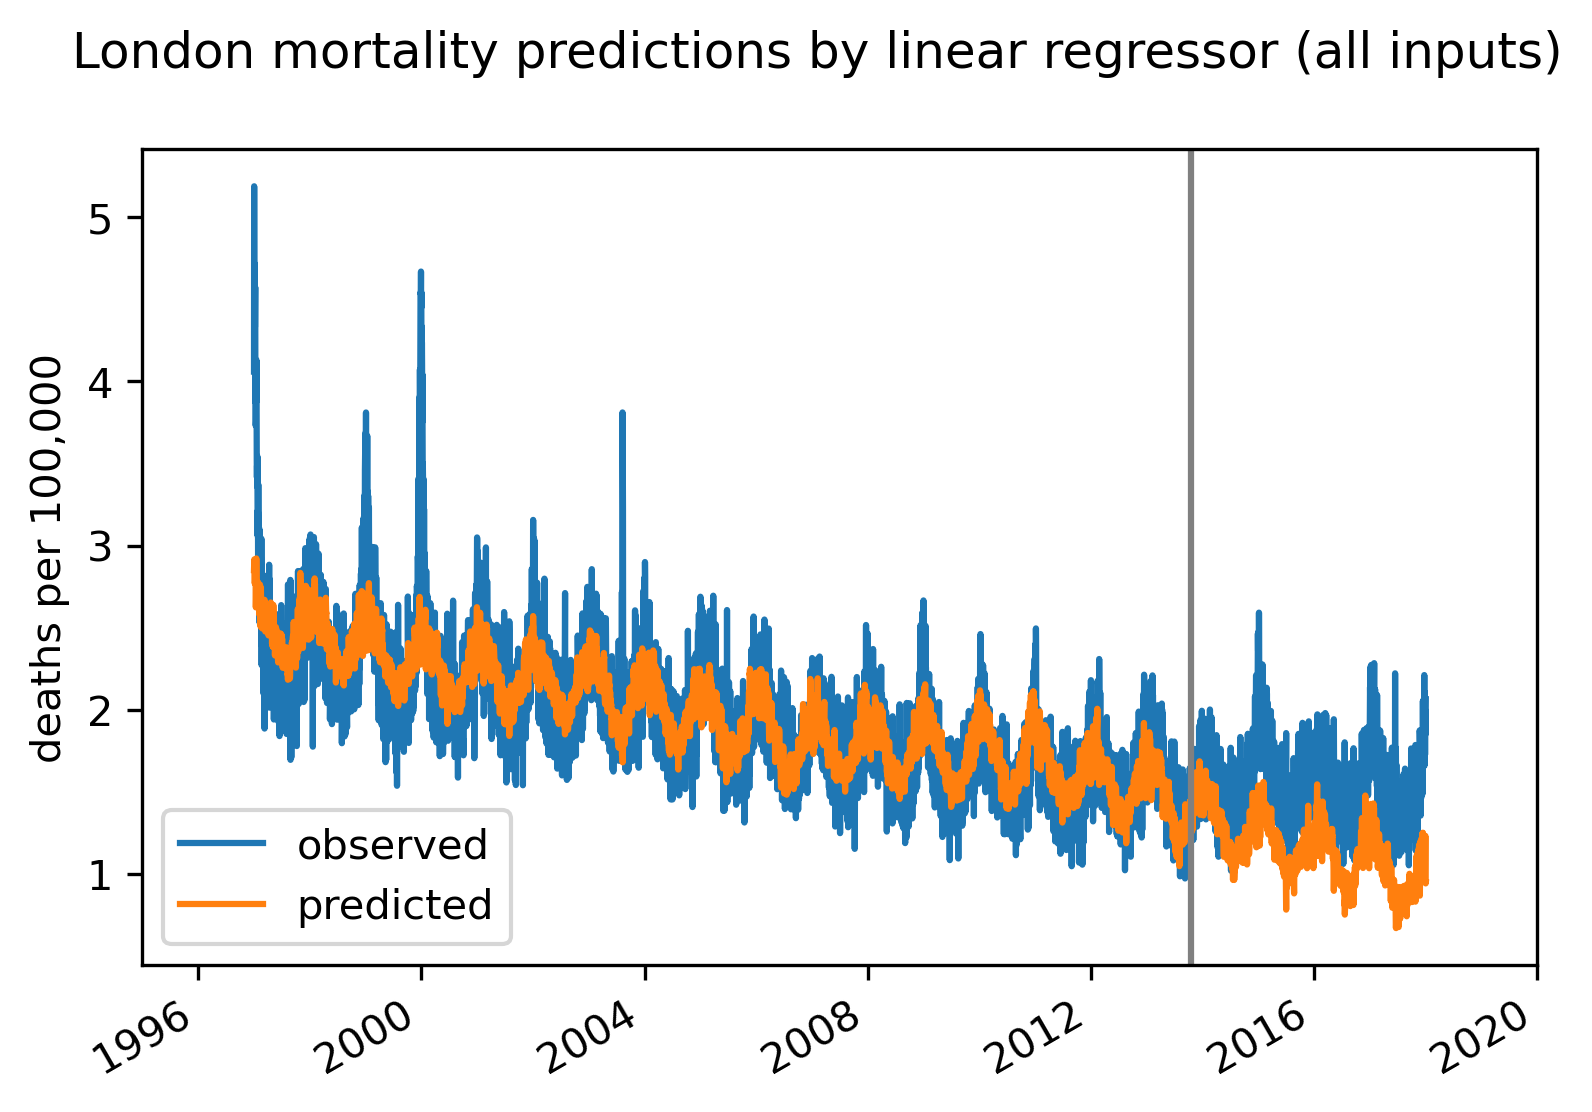

In [70]:
plt.figure(figsize=(6,4), dpi=300)
df["observed"].plot()
df["predicted"].plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
plt.axvline(data_dict["validat_dates"].max(), color="grey") if config["val_size"] else None
plt.legend()
plt.ylabel("deaths per 100,000")
plt.xlim(dt(year=1995, month=1, day=1), dt(year=2020, month=1, day=1))
model_title = config["architecture"].replace("_", " ")
plt.suptitle(f"London mortality predictions by {model_title} {plot_title_model}")
plt.show()